# Causal Survival Analysis
The modules under `causallib.estimation` estimate treatment effect on outcomes that are measured at a particular time point (e.g., effect of smoking cessation on weight gain measured in 1982, or a binary outcome indicating occurrence of event within a specified observation period). Often, however, we are concerned with estimating treatment effect on the *expected time until the occurrence of an event*. This is called survival analysis, and when coupled with confounders adjustment, it is *causal survival analysis*. Modules for causal survival analysis can be found under `causallib.survival`.   
This example notebook uses the NHEFS (National Health Epidemiologic Followup Study) data. It includes 1629 cigarette smokers who were aged 25-74 years at baseline and who were alive through the year 1982. All 1629 individuals were then followed for a period of 10 years, in which 318 of them died before the end of 1992, so the survival time of the remaining 1311 individuals is aministratively censored at 10 years. "Treatment assignment" was smoking cessation status, with `A=1` indicating quitters and `A=0` indicatong non-quitters.   
We follow the analyses suggested by Hernán and Robins in their [Causal Inference book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/) to estimate the effect of smoking cessation on death.

## Data
We start by loading the dataset (with some pre-processing, e.g. column selection and creation of square features/dummy varialbes).  
In addition to the standard `causallib` inputs of `X` - baseline covariates, `a` - treatment assignment and `y` - outcome indicator,
a new variable `t` is introduced, measuring time from the beginning of observation period to an occurrence of event. 
An event may be right-censoring (where `y=0`) or an outcome of interest, or "death" (where `y=1`, which is also a type of censoring).  

In [1]:
from causallib.datasets.data_loader import load_nhefs_survival

# Load and pre-process NHEFS data
data = load_nhefs_survival()
X, a, t, y = data.X, data.a, data.t, data.y
print(f"X shape = {X.shape}")
X.head()

X shape = (1629, 18)


,sex,race,age,smokeintensity,smokeyrs,wt71,age^2,wt71^2,smokeintensity^2,smokeyrs^2,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2
0,0,1,42,30,29,79.04,1764,6247.3216,900,841,0,0,0,0,0,0,0,1
1,0,0,36,20,24,58.63,1296,3437.4769,400,576,0,0,1,0,0,0,0,0
2,1,1,56,20,26,56.81,3136,3227.3761,400,676,0,0,1,0,0,0,0,1
3,0,1,68,3,53,59.42,4624,3530.7364,9,2809,1,0,0,0,0,0,0,1
4,0,0,40,20,19,87.09,1600,7584.6681,400,361,1,0,1,0,0,0,1,0


In [2]:
import pandas as pd

pd.crosstab(a, y, margins=True)

death,0,1,All
qsmk,,,
0,985,216,1201
1,326,102,428
All,1311,318,1629


We see that 26.3% (428/1629) of individuals quit smoking, out of which 76.17% (326/428) survived at 10 years. In contrast, 82% (985/1201) of the NON-quitters survived. This is a surprising result, knowing the well-established health hazards of smoking. Of course, the quitters and non-quitters are not exchangable, meaning that treatment assignment is correlated with baseline covariates, such as age:

In [3]:
pd.DataFrame([X.age, a]).T.groupby("qsmk").agg({"age": "mean"})  # qsmk = quit smoking indicator

,age
qsmk,
0,42.924230
1,46.696262


Mean age was 46.7 for quitters and 43 for non-quitters, which might explain (at least some) of the excess mortality in the quitters group. We'll start by plotting unadjusted Kaplan-Meier curves, using the popular [`lifelines`](https://github.com/CamDavidsonPilon/lifelines) survival analysis Python package.

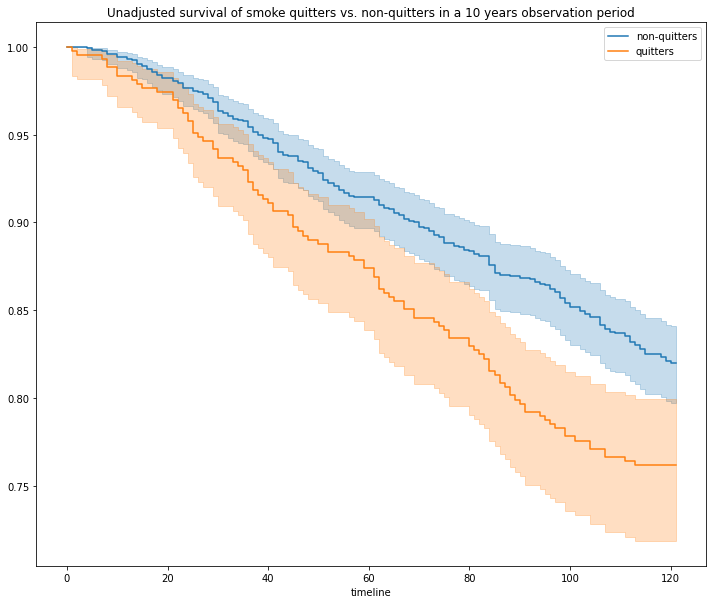

In [4]:
%matplotlib inline
import lifelines
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 10]

fig = plt.figure()
ax = plt.axes()

kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations=t[a == 0], event_observed=y[a == 0], label="non-quitters")
kmf.plot_survival_function(ax=ax)
kmf.fit(durations=t[a == 1], event_observed=y[a == 1], label="quitters")
kmf.plot_survival_function(ax=ax)

plt.title("Unadjusted survival of smoke quitters vs. non-quitters in a 10 years observation period")
plt.show()

Unadjusted curves may also be computed with a built-in implementation using `causallib.survival.MarginalSurvival` (e.g., if [`lifelines`](https://github.com/CamDavidsonPilon/lifelines) is not installed)

In [5]:
def plot_survival_curves(curves, labels, title):
    survival_0 = round(100.0 * curves[0].values[-1], 2)
    survival_1 = round(100.0 * curves[1].values[-1], 2)
    diff = round(survival_1 - survival_0, 2)
    text = f"Survival at 10 years, {labels[1]} : {survival_1}%, {labels[0]} : {survival_0}%, diff: {diff}%"
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(curves[0], label=labels[0])
    ax.plot(curves[1], label=labels[1])
    ax.grid()
    plt.legend()
    plt.title(title)
    plt.text(0, -0.1, text, transform=ax.transAxes, fontsize=14)
    plt.show()

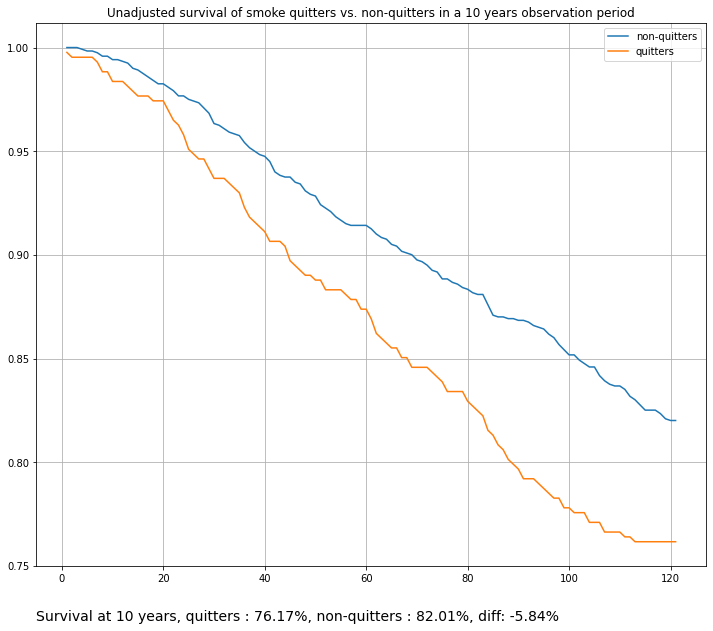

In [6]:
from causallib.survival.marginal_survival import MarginalSurvival

marginal_survival = MarginalSurvival()
marginal_survival.fit(X, a, t, y)
population_averaged_survival_curves = marginal_survival.estimate_population_outcome(X, a, t, y)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="Unadjusted survival of smoke quitters vs. non-quitters in a 10 years observation period",
)

Accounting for censoring (in this case, only death events), we still see a difference in survival at 10 years, in favor of cigarette smokers. A surprising result.

## WeightedSurvival
See section 17.4 ("IP weighting of marginal structural models") of the [Causal Inference book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/).  
  
  
We can adjust for confounders by using `causallib`'s `WeightEstimator` (such as `IPW`) to generate a weighted pseudo-population, in which the quitters and non-quitters are exchangable. Then, we can compute survival curves on this weighted population to get an un-confounded effect.


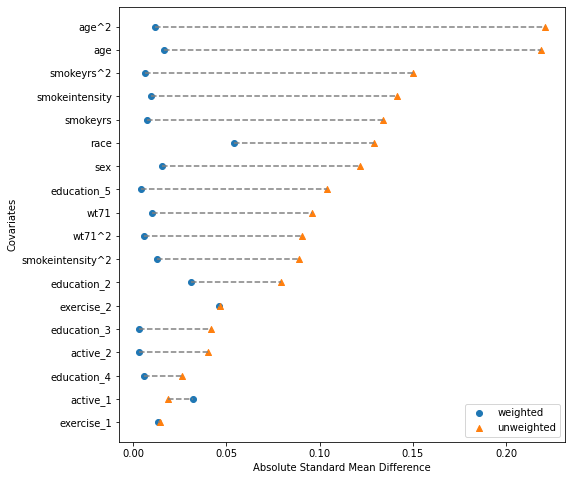

In [7]:
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression

from causallib.estimation import IPW
from causallib.evaluation import evaluate

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

# Fit an inverse propensity model
ipw = IPW(learner=LogisticRegression(max_iter=800))
ipw.fit(X, a)

# Evaluate
evaluation_results = evaluate(ipw, X, a, y, metrics_to_evaluate={})
f, ax = plt.subplots(figsize=(8, 8))
evaluation_results.plot_covariate_balance(kind="love", ax=ax, phase="train");

We now have an `IPW` module that achieves good feature balancing (SMD < 0.1 for all features after weighting).
Let's combine `IPW` with survival analysis, using the `causalib.survival.WeightedSurvival` module.

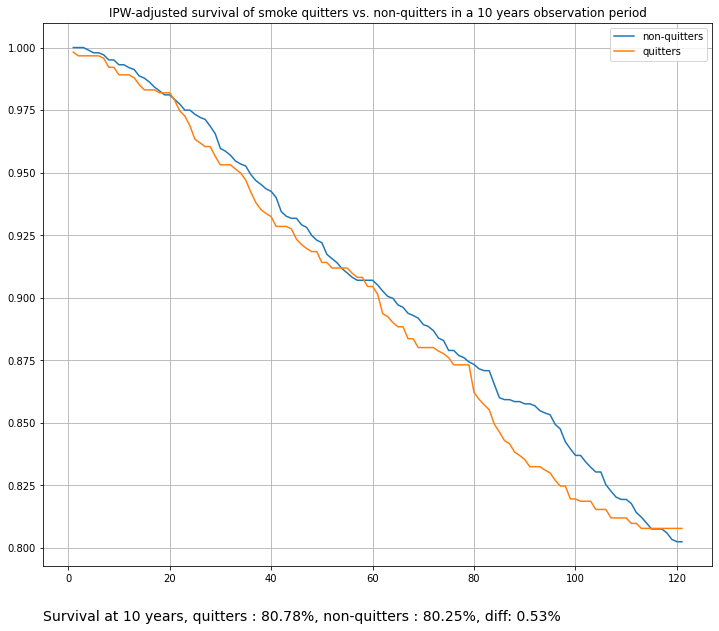

In [8]:
from causallib.survival.weighted_survival import WeightedSurvival

# Compute adjusted survival curves
weighted_survival = WeightedSurvival(weight_model=ipw)
weighted_survival.fit(
    X, a
)  # fit weight model (we can actually skip this since it was already fitted above)
population_averaged_survival_curves = weighted_survival.estimate_population_outcome(X, a, t, y)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="IPW-adjusted survival of smoke quitters vs. non-quitters in a 10 years observation period",
)

The difference in survival at 10 years diminishes after adjustments (probably to the point of being insignificant. Can be determined by bootstrap sampling, for example).   
These curves were generated with an internal, non-parametric default Kaplan-Meier estimator. They can be further smoothed by using a parametric hazards model instead. Note that a weighted hazards model is conditioned on time only, e.g., it does not take covariates into account (unlike Standardization, see below).

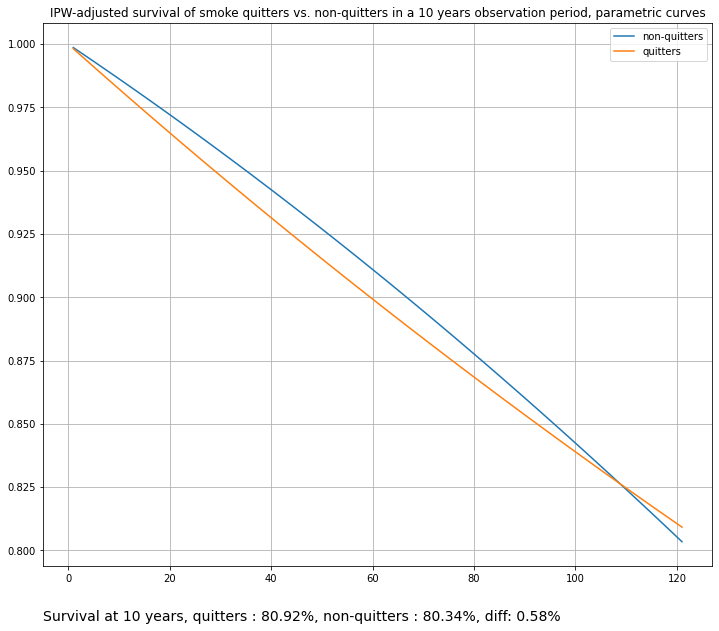

In [9]:
# Compute adjusted survival curves with a parametric hazards model
weighted_survival = WeightedSurvival(
    weight_model=ipw, survival_model=LogisticRegression()
)  # note the survival_model param (use a parametric hazards model)
weighted_survival.fit(X, a)
population_averaged_survival_curves = weighted_survival.estimate_population_outcome(X, a, t, y)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="IPW-adjusted survival of smoke quitters vs. non-quitters in a 10 years observation period, parametric curves",
)

These curves may be TOO smooth, as they were modeled with a linear hazards model. We can use a more expressive alternative with some feature engineering:

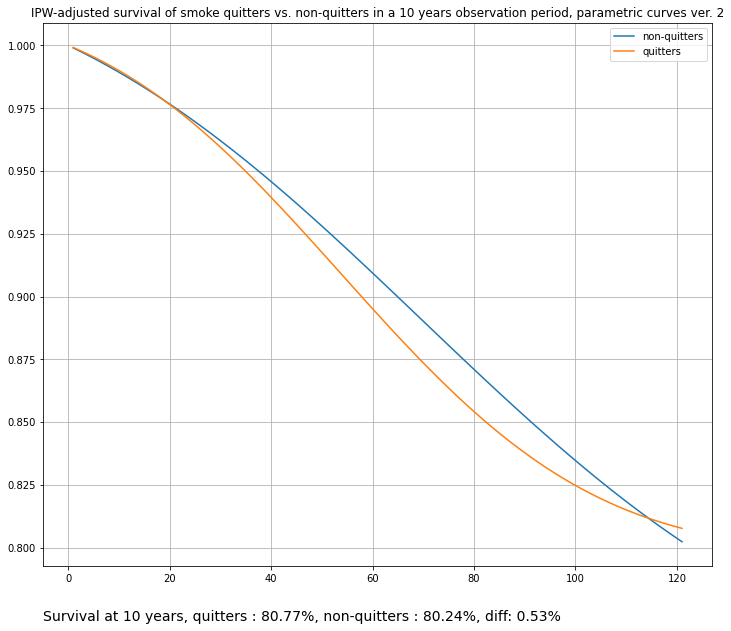

In [10]:
# Compute adjusted survival curves with a parametric hazards model and feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Init sklearn pipeline with feature transformation and logistic regression
pipeline = Pipeline(
    [("transform", PolynomialFeatures(degree=2)), ("LR", LogisticRegression(max_iter=1000))]
)

weighted_survival = WeightedSurvival(
    weight_model=ipw, survival_model=pipeline
)  # note the survival_model param (use a parametric hazards model)
weighted_survival.fit(X, a)
population_averaged_survival_curves = weighted_survival.estimate_population_outcome(X, a, t, y)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="IPW-adjusted survival of smoke quitters vs. non-quitters in a 10 years observation period, parametric curves ver. 2",
)

Alternatively, we can plug-in any `UnivariateFitter` from the [`lifelines`](https://github.com/CamDavidsonPilon/lifelines) package, such as PiecewiseExponentialFitter or WeibullFitter:

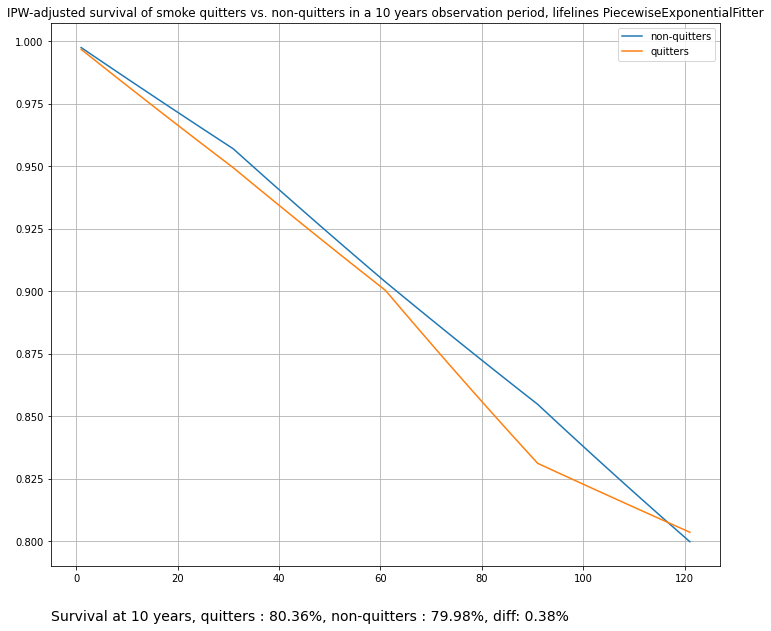

In [11]:
# Compute adjusted survival curves with a lifelines PieacewiseExponentialFitter
weighted_survival = WeightedSurvival(
    weight_model=ipw,
    survival_model=lifelines.PiecewiseExponentialFitter(breakpoints=range(1, 120, 30)),
)
weighted_survival.fit(X, a)
population_averaged_survival_curves = weighted_survival.estimate_population_outcome(X, a, t, y)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="IPW-adjusted survival of smoke quitters vs. non-quitters in a 10 years observation period, lifelines PiecewiseExponentialFitter",
)

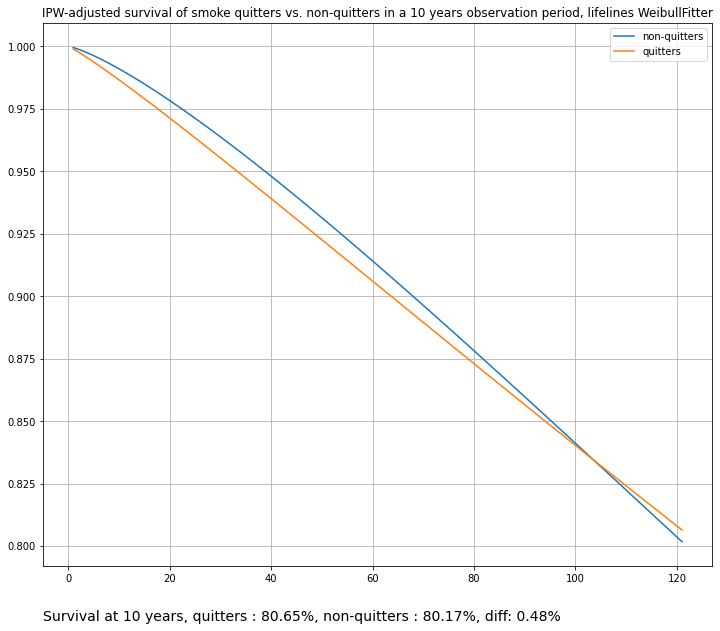

In [12]:
# Compute adjusted survival curves with a lifelines WeibullFitter
weighted_survival = WeightedSurvival(weight_model=ipw, survival_model=lifelines.WeibullFitter())
weighted_survival.fit(X, a)
population_averaged_survival_curves = weighted_survival.estimate_population_outcome(X, a, t, y)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="IPW-adjusted survival of smoke quitters vs. non-quitters in a 10 years observation period, lifelines WeibullFitter",
)

## StandardizedSurvival
See section 17.5 ("The parametric g-formula") of the [Causal Inference book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/).    
  
  
In parametric standardization, also known as the "parametric g-formula", survival at time step `k` is a weighted average of the conditional survivals within levels of covariates `X` and treatment assignment `a`, with the proportion of individuals in each stratum as the weights. In other words, similarly to a standardization with a simple outcome model (S-Learner), we fit a hazards model that *also includes baseline covariates*. This hazards model is then used to compute survival curves.

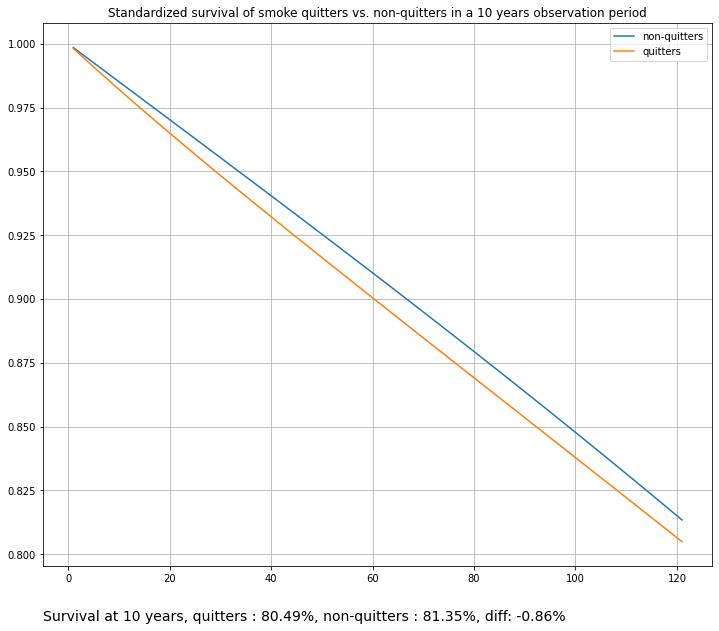

In [13]:
from causallib.survival.standardized_survival import StandardizedSurvival

standardized_survival = StandardizedSurvival(survival_model=LogisticRegression(max_iter=4000))
standardized_survival.fit(X, a, t, y)
population_averaged_survival_curves = standardized_survival.estimate_population_outcome(X, a, t)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="Standardized survival of smoke quitters vs. non-quitters in a 10 years observation period",
)

Or instead of plugging in an skelarn estimator, we can use a `RegressionFitter` from the [`lifelines`](https://github.com/CamDavidsonPilon/lifelines) package, such as the Cox Proportional Hazards Fitter:

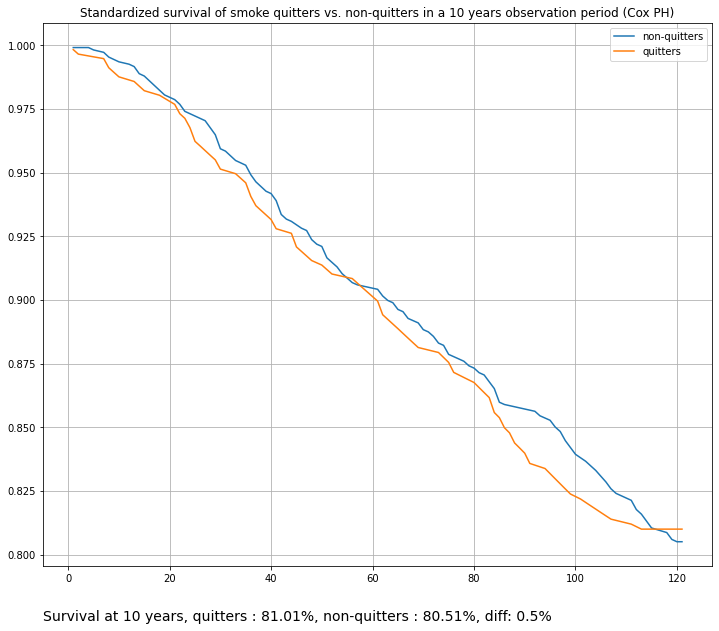

In [14]:
# Use lifelines Cox Proportional Hazards Fitter as a survival model for standardization
standardized_survival_cox = StandardizedSurvival(survival_model=lifelines.CoxPHFitter())
standardized_survival_cox.fit(X, a, t, y)
population_averaged_survival_curves = standardized_survival_cox.estimate_population_outcome(X, a, t)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="Standardized survival of smoke quitters vs. non-quitters in a 10 years observation period (Cox PH)",
)

Since in Standardization we model point hazard conditioned on both covariates and time, it is important to have a well specified model. Using a too simple linear model might result in "rigid", overly simplified survival curves.
Here we add additional time features with the help of a [custom scikit-learn transformer](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers) to yield smoother curves. Compare with the first plot on the StandardizedSurvival section above (cell 13).

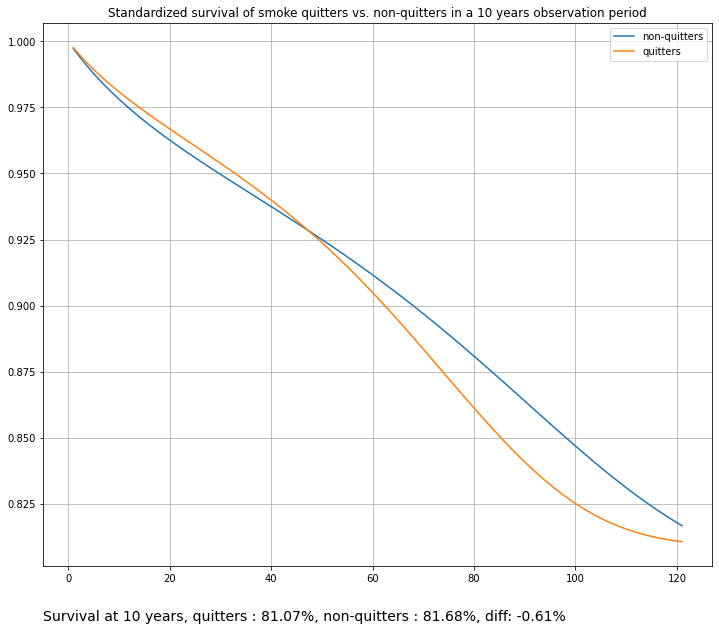

In [15]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class TimeTransform(BaseEstimator, TransformerMixin):
    """
    Simple transformer for adding time points transformations
    """

    def __init__(self, time_col_name):
        super().__init__()
        self.time_col_name = time_col_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.time_col_name + "^2"] = X_[self.time_col_name] ** 2
        X_[self.time_col_name + "^3"] = X_[self.time_col_name] ** 3
        X_[self.time_col_name + "_sqrt"] = np.sqrt(X_[self.time_col_name])
        return X_


time_transform_pipeline = Pipeline(
    [("transform", TimeTransform(time_col_name=t.name)), ("LR", LogisticRegression(max_iter=2000))]
)
standardized_survival = StandardizedSurvival(survival_model=time_transform_pipeline)
standardized_survival.fit(X, a, t, y)
population_averaged_survival_curves = standardized_survival.estimate_population_outcome(X, a, t)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="Standardized survival of smoke quitters vs. non-quitters in a 10 years observation period",
)

## Weighted Standardized Survival
We may also combine weighting with standardization, using the `WeightedStandardizedSurvival` module. Here we combine an inverse propensity weighting model (to re-weight population based on their baseline covariates) and then run a weighted regression with a Standardization model:

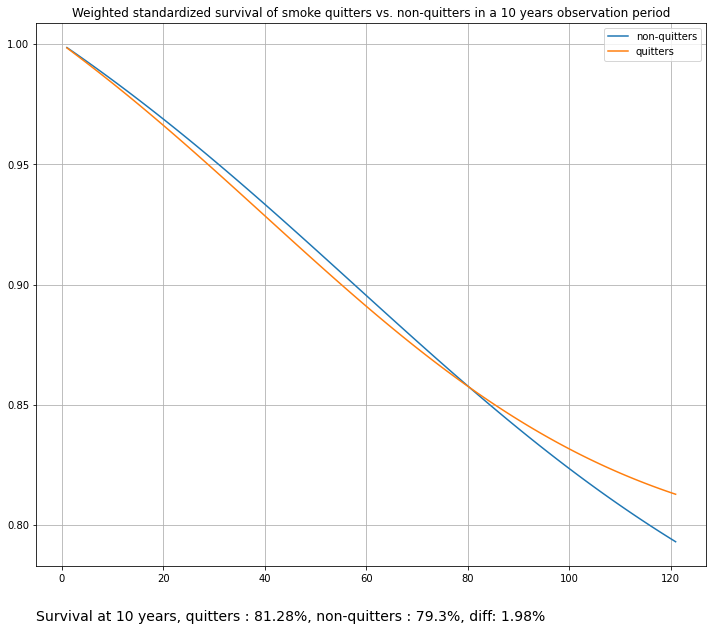

In [16]:
from causallib.survival.weighted_standardized_survival import WeightedStandardizedSurvival

ipw = IPW(learner=LogisticRegression(max_iter=2000))
poly_transform_pipeline = Pipeline(
    [("transform", PolynomialFeatures(degree=2)), ("LR", LogisticRegression(max_iter=8000, C=1.5))]
)
weighted_standardized_survival = WeightedStandardizedSurvival(
    survival_model=poly_transform_pipeline, weight_model=ipw
)
weighted_standardized_survival.fit(X, a, t, y)

population_averaged_survival_curves = weighted_standardized_survival.estimate_population_outcome(
    X, a, t
)

plot_survival_curves(
    population_averaged_survival_curves,
    labels=["non-quitters", "quitters"],
    title="Weighted standardized survival of smoke quitters vs. non-quitters in a 10 years observation period",
)

Or instead of plugging in an skelarn estimator, we can use a `RegressionFitter` from the [`lifelines`](https://github.com/CamDavidsonPilon/lifelines) package, such as the Cox Proportional Hazards Fitter. This is a _weighted Cox analysis_.

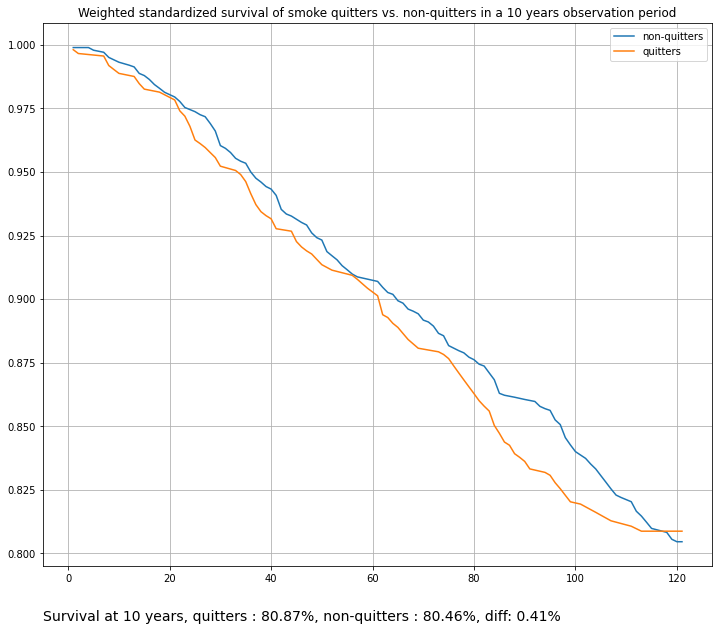

In [17]:
ipw = IPW(learner=LogisticRegression(max_iter=1000))
weighted_standardized_survival = WeightedStandardizedSurvival(survival_model=lifelines.CoxPHFitter(), weight_model=ipw)

# Note the fit_kwargs (passed to CoxPHFitter.fit() method)
weighted_standardized_survival.fit(X, a, t, y, fit_kwargs={'robust': True})

# Without setting 'robust=True', we'll get the following warning:
"""StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances."""


population_averaged_survival_curves = weighted_standardized_survival.estimate_population_outcome(X, a, t)

plot_survival_curves(population_averaged_survival_curves, 
                     labels=['non-quitters', 'quitters'], 
                     title='Weighted standardized survival of smoke quitters vs. non-quitters in a 10 years observation period')

## Summary
Side by side comparison of multiple models.

In [18]:
import itertools


def plot_multiple_models(models_dict):
    grid_dims = (int(np.round(np.sqrt(len(models_dict)))), int(np.ceil(np.sqrt(len(models_dict)))))
    grid_indices = itertools.product(range(grid_dims[0]), range(grid_dims[1]))
    fig, ax = plt.subplots(*grid_dims)
    models_names = list(models_dict.keys())

    for model_name, plot_idx in zip(models_names, grid_indices):
        model = models_dict[model_name]
        model.fit(X, a, t, y)
        curves = model.estimate_population_outcome(X, a, t, y)
        ax[plot_idx].plot(curves[0])
        ax[plot_idx].plot(curves[1])
        ax[plot_idx].set_title(model_name)
        ax[plot_idx].set_ylim(0.7, 1.02)
        ax[plot_idx].grid()

    plt.tight_layout()
    plt.show()

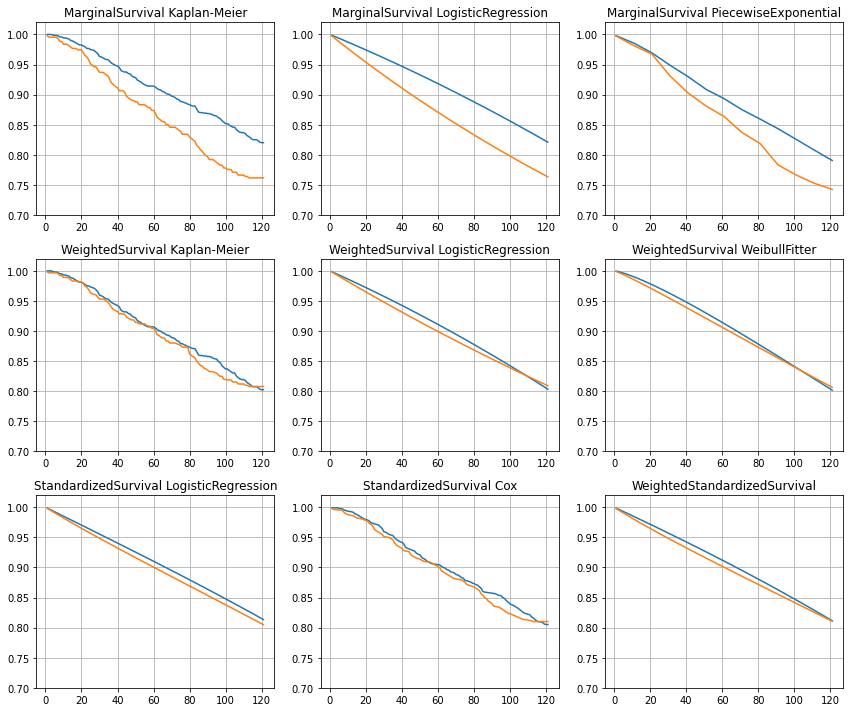

In [19]:
MODELS_DICT = {
    "MarginalSurvival Kaplan-Meier": MarginalSurvival(survival_model=None),
    "MarginalSurvival LogisticRegression": MarginalSurvival(
        survival_model=LogisticRegression(max_iter=2000)
    ),
    "MarginalSurvival PiecewiseExponential": MarginalSurvival(
        survival_model=lifelines.PiecewiseExponentialFitter(breakpoints=range(1, 120, 10))
    ),
    "WeightedSurvival Kaplan-Meier": WeightedSurvival(
        weight_model=IPW(LogisticRegression(max_iter=2000)), survival_model=None
    ),
    "WeightedSurvival LogisticRegression": WeightedSurvival(
        weight_model=IPW(LogisticRegression(max_iter=2000)),
        survival_model=LogisticRegression(max_iter=2000),
    ),
    "WeightedSurvival WeibullFitter": WeightedSurvival(
        weight_model=IPW(LogisticRegression(max_iter=2000)),
        survival_model=lifelines.WeibullFitter(),
    ),
    "StandardizedSurvival LogisticRegression": StandardizedSurvival(
        survival_model=LogisticRegression(max_iter=2000)
    ),
    "StandardizedSurvival Cox": StandardizedSurvival(survival_model=lifelines.CoxPHFitter()),
    "WeightedStandardizedSurvival": WeightedStandardizedSurvival(
        weight_model=IPW(LogisticRegression(max_iter=2000)),
        survival_model=LogisticRegression(max_iter=2000),
    ),
}

plot_multiple_models(MODELS_DICT)